In [1]:
import os
import string
import random

import numpy as np
import pandas as pd

from itertools import zip_longest
from collections import Counter

import math
import json
import re
import statistics
from scipy import stats

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, classification_report, confusion_matrix, plot_confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, KFold, StratifiedKFold, cross_val_score, cross_val_predict
import matplotlib.pyplot as plt

import xgboost as xgb
import lightgbm as lgb
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 7

from sklearn import decomposition
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import pickle

/home/vanilla_skies/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: alpha is an invalid version and will not be supported in a future release
  warnings.warn(
/home/vanilla_skies/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/vanilla_skies/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
DATA_PATH = "bankruptcy/train"
TEST_PATH = "bankruptcy/sample"

In [3]:
# all data files from each path stored in each dictionary
def data_reading(PATH):
    data_files = {}
    
    for file_name in os.listdir(PATH):
        print("Reading file: ", file_name)
        
        curr_table = pd.read_csv(os.path.join(PATH, file_name), index_col=['Id'], low_memory=False)
        curr_table.replace('?', np.nan, inplace = True)
        curr_table.iloc[:, :-1] = curr_table.iloc[:, :-1].astype(np.float64)
        
        # fill missing value with median
        imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
        curr_table.loc[:, curr_table.columns!='Bankrupt'] = imp_mean.fit_transform(curr_table.loc[:, curr_table.columns!='Bankrupt'])
        
        # save
        data_files[file_name[:-4]] = curr_table
    
    print("Finished Reading for Folder: ", PATH)
    return data_files

In [4]:
def drop_numerical_outliers(df, z_thresh=3):
    print('Before dropping outliers: ', df.shape)
    # Constrains will contain `True` or `False` depending on if it is a value below the threshold.
    constrains = df.iloc[:,:-1].select_dtypes(include=[np.number]) \
        .apply(lambda x: np.abs(stats.zscore(x)) < z_thresh) \
        .all(axis=1)
    print(constrains)
    # Drop (inplace) values set to be rejected
    df.drop(df.index[~constrains], inplace=True)
    print('After dropping outliers: ', df.shape)
    return df

In [5]:
train_files = data_reading(DATA_PATH)
test_files = data_reading(TEST_PATH)

Reading file:  5th_yr.csv
Reading file:  1st_yr.csv
Reading file:  4th_yr.csv
Reading file:  3rd_yr.csv
Reading file:  2nd_yr.csv
Finished Reading for Folder:  bankruptcy/train
Reading file:  5th_yr.csv
Reading file:  1st_yr.csv
Reading file:  4th_yr.csv
Reading file:  3rd_yr.csv
Reading file:  2nd_yr.csv
Finished Reading for Folder:  bankruptcy/sample


In [6]:
model_names = []
model_scores = []

In [7]:
def create_training_data(X, y, sampling_technique = 1, test_size = 0.33):
    """
    This creates a training_testing data
    Parameters
    ----------
    sampling_technique: int
        sampling_technique = 1 then oversample using SMOTE
        sampling_technique = 2 then undersample
        sampling_technique = 3 then do nothing
    Returns
    -------
    X, y, X_train, X_test, y_train, y_test : np.ndarray
    """
    X = np.squeeze(X)
    y = np.asarray(y)
    
    if type(y[0]) != int:
        print("encode labels")
        le = LabelEncoder()    
        y = le.fit_transform(y)
        #exporting the departure encoder
        output = open('label_encoder.pkl', 'wb')
        pickle.dump(le, output)
        output.close()
        
    if sampling_technique == 1:
        oversample = SMOTE()
        X, y = oversample.fit_resample(X, y)
    elif sampling_technique == 2:
        undersample = RandomUnderSampler()
        X, y = undersample.fit_resample(X, y)
    else:
        pass
    counter = Counter(y)
    for k, v in counter.items():
        per = v / len(y) * 100
        print('Class={}, n={} ({})'.format(k, v, per))
    print(type(X), X.shape)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= test_size, random_state=42, stratify=y)
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    return X, y, X_train, X_test, y_train, y_test

In [8]:
def eval_model(model, model_name, X, y, X_train, X_test, y_train, y_test, encode = False, cv_10 = True, verbose = False, cv = 10):
    """
    This evaluates a model
    Parameters
    ----------
    model : model
    model_name : string
    Returns
    -------
    None
    """
    
    pkl_file = open('label_encoder.pkl', 'rb')
    label_encoder = pickle.load(pkl_file) 
    pkl_file.close()
    
    label_encoder_dict = dict(zip(range(len(label_encoder.classes_)),label_encoder.classes_))

    # first 10 fold cross validation
    if cv_10 == True:
        print('10 FOLD CV')
        scores = cross_val_score(model, X, y, cv = cv)
        print('all scores: ', scores)
        print('scores mean: {} scores median: {}'.format(np.mean(scores), np.median(scores)))
    
    print('80-20 SPLIT')
    model = model.fit(X_train, y_train)
    
    # global y_test, model_names, model_scores
    score_of_the_model = model.score(X_test, y_test)
    print('model score: {}'.format(score_of_the_model))
    
    model_names.append(model_name)
    model_scores.append(score_of_the_model)
    
    y_pred = model.predict(X_test)
    if verbose == True:
        print('y_tests are: {}'.format(y_test))
        print('y_pred are: {}'.format(y_pred))
    
    if encode == True:
        y_test = np.argmax(y_test, axis=1)
        y_pred = np.argmax(y_pred, axis=1)
    
    if verbose == True:
        print('first 20 y_test values:  {}'.format(y_test[:20]))
        print('first 20 y_pred values: {}'.format(y_pred[:20]))
    print('r2 score: {}'.format(r2_score(y_test, y_pred)))
    print('classification report: \n {}'.format(classification_report(y_test, y_pred)))
    confusion_matrix_curr = confusion_matrix(y_test, y_pred, labels=np.unique(y))
    # plt.imshow(confusion_matrix_curr)
    # plt.title('confusion matrix')
    # plt.show()
    # plt.figure()
    
    # y_pred_proba = model.predict_proba(X_test)[::,1]
    # fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    
    
    if encode == False:
        plot_confusion_matrix(model, X_test, y_test)  
        plt.show()
    else:
        print('nothing to see here.')
    
    print("model: " + str(model_name) + "confusion matrix: \n", confusion_matrix_curr)
    print("model: " + str(model_name) + " accuracy: ", accuracy_score(y_test, y_pred))
    TN = confusion_matrix_curr[0][0]
    FN = confusion_matrix_curr[1][0]
    TP = confusion_matrix_curr[1][1]
    FP = confusion_matrix_curr[0][1]
    
    try:
        print("For model: " + str(model_name) + "\n")
        print('True Negative ',TN, '\nFalse Negative ', FN, '\nTrue Positive', TP, '\nFalse Positive ', FP)
        accuracy = (TP+TN)/(TP+TN+FP+FN)
        recall = TP/(TP+FN)
        precision = TP/(TP+FP)
        print('Accuracy:\t',accuracy)
        print('Precision:\t',precision)
        print('Recall:\t',recall)
        model_acc_recall_precision[model_name] = [accuracy, precision, recall]
    except:
        print("accuracy, precision, recall not calculated.")
    return model

In [9]:
year = '5th_yr'
data = train_files[year].copy()
data = drop_numerical_outliers(data)
y = data.loc[:,'Bankrupt']
X = data.loc[:, data.columns!='Bankrupt']
X, y, X_train, X_test, y_train, y_test = create_training_data(X, y.tolist(), 1, test_size = 0.30)

Before dropping outliers:  (4818, 65)
Id
1188     True
1654     True
3864     True
3578     True
2028    False
        ...  
2337     True
2747     True
2982     True
1974    False
1505     True
Length: 4818, dtype: bool
After dropping outliers:  (4472, 65)
encode labels
Class=0, n=4212 (50.0)
Class=1, n=4212 (50.0)
<class 'pandas.core.frame.DataFrame'> (8424, 64)
(5896, 64) (2528, 64) (5896,) (2528,)


10 FOLD CV
all scores:  [0.73190985 0.75326216 0.75326216 0.75682088 0.71377672 0.73871734
 0.75771971 0.74228029 0.76484561 0.75771971]
scores mean: 0.7470314423941189 scores median: 0.7532621589561092
80-20 SPLIT
model score: 0.7472310126582279
r2 score: -0.011075949367088667
classification report: 
               precision    recall  f1-score   support

           0       0.69      0.89      0.78      1264
           1       0.85      0.60      0.70      1264

    accuracy                           0.75      2528
   macro avg       0.77      0.75      0.74      2528
weighted avg       0.77      0.75      0.74      2528



/home/vanilla_skies/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


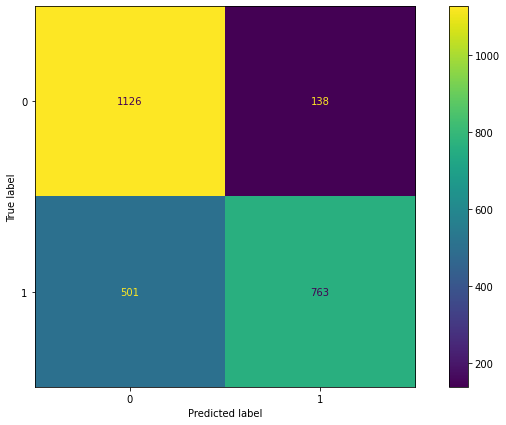

model: RandomForest_oversamplingconfusion matrix: 
 [[1126  138]
 [ 501  763]]
model: RandomForest_oversampling accuracy:  0.7472310126582279
For model: RandomForest_oversampling

True Negative  1126 
False Negative  501 
True Positive 763 
False Positive  138
Accuracy:	 0.7472310126582279
Precision:	 0.8468368479467259
Recall:	 0.6036392405063291
accuracy, precision, recall not calculated.


RandomForestClassifier(max_depth=2, random_state=0)

In [10]:
model = RandomForestClassifier(max_depth=2, random_state=0)
eval_model(model, "RandomForest_oversampling", X, y, X_train, X_test, y_train, y_test)

10 FOLD CV
all scores:  [0.71293001 0.75207592 0.75682088 0.75088968 0.71496437 0.7304038
 0.75653207 0.72327791 0.76484561 0.7672209 ]
scores mean: 0.7429961144312671 scores median: 0.7514827995255042
80-20 SPLIT
model score: 0.7444620253164557
r2 score: -0.02215189873417711
classification report: 
               precision    recall  f1-score   support

           0       0.68      0.91      0.78      1264
           1       0.86      0.58      0.69      1264

    accuracy                           0.74      2528
   macro avg       0.77      0.74      0.74      2528
weighted avg       0.77      0.74      0.74      2528



/home/vanilla_skies/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


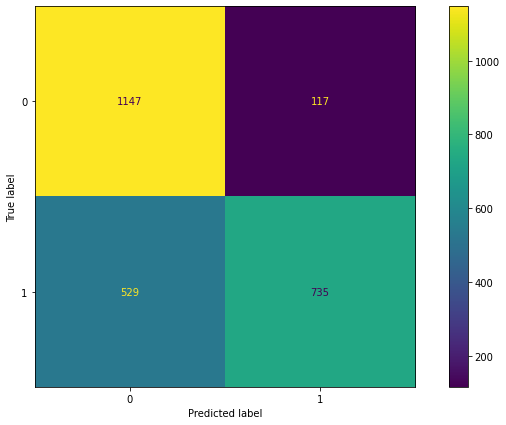

model: DecisionTree_oversamplingconfusion matrix: 
 [[1147  117]
 [ 529  735]]
model: DecisionTree_oversampling accuracy:  0.7444620253164557
For model: DecisionTree_oversampling

True Negative  1147 
False Negative  529 
True Positive 735 
False Positive  117
Accuracy:	 0.7444620253164557
Precision:	 0.8626760563380281
Recall:	 0.5814873417721519
accuracy, precision, recall not calculated.


DecisionTreeClassifier(max_depth=2, random_state=0)

In [11]:
model = DecisionTreeClassifier(random_state=0, max_depth=2)
eval_model(model, "DecisionTree_oversampling", X, y, X_train, X_test, y_train, y_test)

10 FOLD CV
all scores:  [0.84934757 0.90391459 0.90747331 0.90510083 0.86698337 0.88836105
 0.9216152  0.86342043 0.90142518 0.90498812]
scores mean: 0.8912629648101029 scores median: 0.9026698844472997
80-20 SPLIT
model score: 0.8916139240506329
r2 score: 0.5664556962025317
classification report: 
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      1264
           1       0.88      0.90      0.89      1264

    accuracy                           0.89      2528
   macro avg       0.89      0.89      0.89      2528
weighted avg       0.89      0.89      0.89      2528



/home/vanilla_skies/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


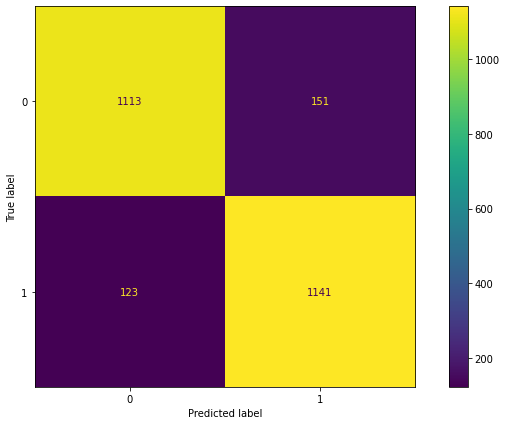

model: LGBM_oversamplingconfusion matrix: 
 [[1113  151]
 [ 123 1141]]
model: LGBM_oversampling accuracy:  0.8916139240506329
For model: LGBM_oversampling

True Negative  1113 
False Negative  123 
True Positive 1141 
False Positive  151
Accuracy:	 0.8916139240506329
Precision:	 0.8831269349845201
Recall:	 0.9026898734177216
accuracy, precision, recall not calculated.


LGBMClassifier(max_depth=2, random_state=0)

In [12]:
model =  lgb.LGBMClassifier(random_state=0, max_depth=2)
eval_model(model, "LGBM_oversampling", X, y, X_train, X_test, y_train, y_test)

10 FOLD CV
all scores:  [0.90272835 0.94661922 0.95492289 0.94543298 0.9216152  0.94299287
 0.95130641 0.92042755 0.93942993 0.95724466]
scores mean: 0.9382720067173285 scores median: 0.9442129257853554
80-20 SPLIT
model score: 0.9343354430379747
r2 score: 0.7373417721518987
classification report: 
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      1264
           1       0.93      0.94      0.94      1264

    accuracy                           0.93      2528
   macro avg       0.93      0.93      0.93      2528
weighted avg       0.93      0.93      0.93      2528



/home/vanilla_skies/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


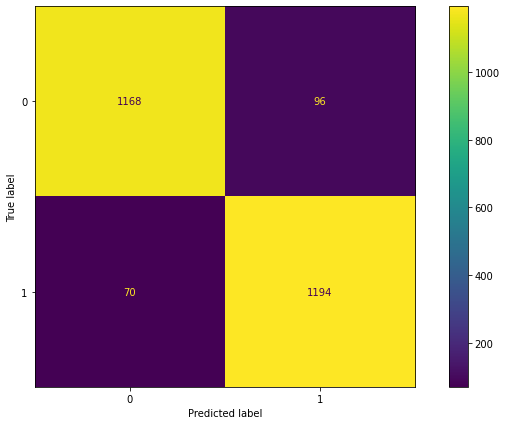

model: XGBoost_oversamplingconfusion matrix: 
 [[1168   96]
 [  70 1194]]
model: XGBoost_oversampling accuracy:  0.9343354430379747
For model: XGBoost_oversampling

True Negative  1168 
False Negative  70 
True Positive 1194 
False Positive  96
Accuracy:	 0.9343354430379747
Precision:	 0.9255813953488372
Recall:	 0.944620253164557
accuracy, precision, recall not calculated.


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [13]:
model =  xgb.XGBClassifier(random_state=0, max_depth=2)
eval_model(model, "XGBoost_oversampling", X, y, X_train, X_test, y_train, y_test)

<AxesSubplot:xlabel='model_names'>

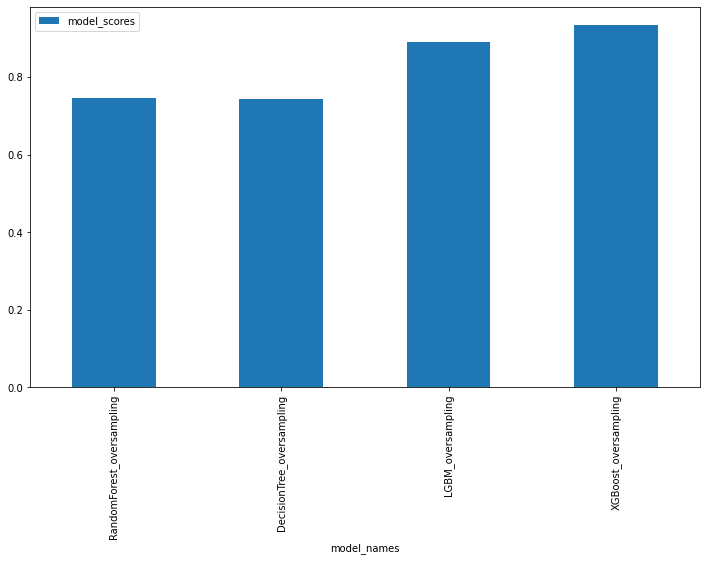

In [14]:
results_dict = {"model_names": model_names, "model_scores": model_scores}
results_df = pd.DataFrame.from_dict(results_dict)
results_df = results_df.set_index('model_names')
results_df.plot.bar()

In [15]:
model = xgb.XGBClassifier(random_state=0, max_depth=2)
model.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [16]:
test_data = test_files[year].copy()

In [17]:
test_data

X1       X2        X3       X4         X5       X6        X7  \
Id                                                                         
5412  0.124220  0.57105  0.422250  1.73940   98.68200  0.00000  0.124220   
1370 -0.192810  0.53936  0.198450  1.69270   17.62000  0.00000 -0.192810   
4605  0.183170  0.42320 -0.168500  0.60184  -11.72000  0.93289  0.183170   
3256  0.119100  0.12672  0.511250  5.03460  152.78000  0.36525  0.151130   
4585  0.135630  0.46398  0.566460  2.32630   20.46000  0.00000  0.135630   
...        ...      ...       ...      ...        ...      ...       ...   
2830  0.062417  0.44645  0.271640  1.96830  -21.00500  0.00000  0.078770   
4291 -0.010877  0.32091 -0.043237  0.86497  -64.42400  0.00000 -0.010877   
4781  0.001756  0.75316  0.201630  1.27600    4.82740  0.00000  0.002700   
3046  0.294390  0.57127  0.068046  1.12020    0.49422  0.51728  0.294390   
4137  0.059982  0.10252  0.375910  4.66680  207.17000  1.87240  0.076252   

           X8       X9      X10  ...       X55       X56       X57      X58  \
Id                               ...                                          
5412  0.75115  1.58620  0.42895  ...   2334.10  0.448830  0.289600  0.55738   
1370  0.85406  1.89090  0.46064  ...    253.35  0.105060 -0.418560  0.89571   
4605  1.35640  1.02340  0.57404  ...   -553.14  0.022846  0.319090  0.97715   
3256  6.03030  1.00770  0.76413  ...   8930.10  0.007606  0.155870  0.99239   
4585  1.15530  5.53440  0.53602  ...   1729.70  0.037904  0.253020  0.97556   
...       ...      ...      ...  ...       ...       ...       ...      ...   
2830  1.23990  1.01620  0.55355  ...  15075.00  0.095759  0.112760  0.92348   
4291  2.11610  0.56048  0.67909  ...   -421.59  0.014477 -0.016017  1.01930   
4781  0.32774  2.21010  0.24684  ...   1628.00  0.091515  0.007115  0.91346   
3046  0.70034  1.15800  0.40008  ...   2473.00  0.136470  0.735830  0.86353   
4137  8.27460  1.11510  0.84830  ...  33358.00  0.103220  0.070708  0.89678   

           X59       X60       X61      X62      X63        X64  
Id                                                               
5412  0.000000    7.1541    2.4049  131.400   2.7777  236.81000  
1370  0.136430   17.5300    5.4019   55.299   6.6005    3.67120  
4605  0.000000  106.7000  160.9500   19.449  18.7670   10.65700  
3256  0.000000   10.7940    3.3616   44.307   8.2380    2.88340  
4585  0.000000   22.6540    7.8523   28.168  12.9580  858.18000  
...        ...       ...       ...      ...      ...        ...  
2830  0.159450    8.2652    6.2052  100.770   3.6223    2.26910  
4291  0.000000   13.2400    4.8617  208.530   1.7503    0.77518  
4781  0.052388   15.2640    3.0147  120.640   3.0254   32.55800  
3046  0.012714   44.4280    9.2947   97.646   3.7380    5.78600  
4137  0.000000   13.0370    2.8732   54.068   6.7507    1.32690  

[482 rows x 64 columns]

In [18]:
model.predict(test_data)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,